# Construction Of Support Vector Machine Feature Spaces Via Deformed Weyl-Heisenberg Algebra

**Abstract**

This paper uses deformed coherent states, based on a deformed Weyl-Heisenberg algebra that unifies the well-known $SU(2)$, Weyl-Heisenberg, and $SU(1,1)$ groups, through a common  parameter $\alpha$.
We show that deformed coherent states provide the theoretical foundation of a meta-kernel function, that is a kernel which in turn defines kernel functions.

Kernel functions drive developments in the field of machine learning and the meta-kernel function presented in this paper opens new theoretical avenues for the definition and exploration of kernel functions.

The meta-kernel function applies associated revolution surfaces  as feature spaces identified with non-linear coherent states.  

An empirical investigation compares the $\alpha-SU(2)$ and $\alpha-SU(1,1)$ kernels derived from the meta-kernel which shows performance similar to the Radial Basis kernel, and offers new insights (based on the deformed Weyl-Heisenberg algebra).

## Libraries

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn import datasets
from sklearn.datasets import make_blobs, make_moons, make_circles
from sklearn.model_selection import validation_curve
from sklearn.model_selection import learning_curve
from sklearn.pipeline import Pipeline
from sklearn import svm

# Machine Learning libraries
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import model_from_json
import tensorflow as tf

from base import Kernel
from svm_vis import plot_dataset
from svm_vis import plot_decision_boundary
from svm_vis import plot_iris_data
from svm_vis import plot_learning_curve
from mlxtend.plotting import plot_decision_regions

from abc import abstractmethod, ABCMeta
from cmath import *

import pickle

import time
import re

import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
sns.set()

In [2]:
MY_PATH = "./"

## Defining Kernels

### My RBF Kernel


$$
K(x,y) = e^{-\gamma \left|\left| x - y \right| \right|^2}
$$

In [5]:
# Radial Basis Function kernel, defined as unnormalized Gaussian PDF
#        K(x, y) = e^(-g||x - y||^2)
#  where:
#        g = gamma
class myRBF(Kernel):

    # class constructor with param gamma
    def __init__(self, gamma=None):
        self._gamma = gamma
  
    # define kernel
    def _compute(self, data_1, data_2):
        if self._gamma is None:
            self._gamma = 1./data_1.shape[1]  # libSVM heuristics

        dists_sq = euclidean_dist_matrix(data_1, data_2)
        return np.exp(-self._gamma * dists_sq)

    def dim(self):
        return np.inf

# Returns matrix of pairwise, squared Euclidean distances
def euclidean_dist_matrix(data_1, data_2):
    norms_1 = (data_1 ** 2).sum(axis=1)
    norms_2 = (data_2 ** 2).sum(axis=1)
    
    return np.abs(norms_1.reshape(-1, 1) + norms_2 - 2 * np.dot(data_1, data_2.T))


### SU(1,1)

$$
K(x, y) = \prod \left[ \frac{1 - \tanh^2\left( z \sqrt{\frac{| \alpha |}{2}} \right)}{1 - \tanh^2\left( z \sqrt{\frac{| \alpha |}{2}} \right)e^{i\left( x - y \right)}}  \right]^{2k}
$$

In [6]:
class SU1Kernel(Kernel):

    # class constructor with params alpha, z and k
    def __init__(self, alpha=1, z=1, k=1):
        self._alpha = alpha
        self._z = z
        self._k = k
        
    # define kernel
    def _compute(self, data_1, data_2):
        #K(x, y) = PROD_i [ (1-tanh^2(z*sqrt(abs(alpha)/2))) / 
        #                   (1-tanh^2(z*sqrt(abs(alpha)/2)))*exp(i(xi - yi)) ]^2k
        kernel = np.ones((data_1.shape[0], data_2.shape[0]))
        
        for d in range(data_1.shape[1]):
            column_1 = data_1[:, d].reshape(-1, 1)
            column_2 = data_2[:, d].reshape(-1, 1)
            
            num = 1.0 - np.tanh( self._z*np.sqrt(np.abs(self._alpha)/2.0) )**2 
            den = 1.0 - (np.tanh( self._z*np.sqrt(np.abs(self._alpha)/2.0) )**2)*np.exp(1j*(column_1 - column_2.T))
            
            kernel = np.multiply(kernel, (num / den)**(2*self._k), out=kernel, casting='unsafe')
        
        return kernel

    def dim(self):
        return np.inf


### SU(2)

$$
K(x, y) = \prod \left[ \frac{1 + \tan^2\left( z \sqrt{\frac{| \alpha |}{2}} \right)e^{i\left( x - y \right)}}{1 + \tan^2\left( z \sqrt{\frac{| \alpha |}{2}} \right)}  \right]^{2k}
$$

In [8]:
class SU2Kernel(Kernel):

    # class constructor with params alpha, z and k
    def __init__(self, alpha=1, z=1, k=1):
        self._alpha = alpha
        self._z = z
        self._k = k
        
    # define kernel
    def _compute(self, data_1, data_2):
        #K(x, y) = PROD_i [  (1+tanh^2(z*sqrt(abs(alpha)/2)))*exp(i(xi - yi))  / 
        #                    (1+tanh^2(z*sqrt(abs(alpha)/2))) ]^2k
        #                  
        kernel = np.ones((data_1.shape[0], data_2.shape[0]))
        for d in range(data_1.shape[1]):
            column_1 = data_1[:, d].reshape(-1, 1)
            column_2 = data_2[:, d].reshape(-1, 1)
            
            num = 1.0 + (np.tan( self._z*np.sqrt(np.abs(self._alpha)/2.0) )**2)*np.exp(1j*(column_1 - column_2.T))
            den = 1.0 + np.tan( self._z*np.sqrt(np.abs(self._alpha)/2.0) )**2 
            
            kernel = np.multiply(kernel, (num / den)**(2*self._k), out=kernel, casting='unsafe')
        return kernel

    def dim(self):
        return np.inf

### Defining Grid Search

#### RBF ( C, G )

In [9]:
# Performs grid search over param space
def grid_search_RBF(X_train, y_train,  X_test, y_test,  test_name, c_space = np.arange(1,101,1), g_space = np.arange(0.001,5.001,0.001)):
    
    res_matrix = np.zeros((len(c_space)*len(g_space),6))
    indx = 0
    
    for c in c_space:
        if (c % 10) == 0:
            print("C = %f\n" %c)

        for g in g_space:
            
            if(len(g_space)==1):
                g = 1./X_train.shape[1]  # libSVM heuristics
            
            clf = svm.SVC(kernel=myRBF(gamma=g), C = c)
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)
            rep = classification_report(y_test,y_pred)
            
            tokens = rep.split("\n")
            avg = tokens[-2]
            toks = re.split(r" +",avg)
            res_matrix[indx,:] = [c, g, float(toks[2]),float(toks[3]),float(toks[4]),float(toks[5])]
            indx = indx + 1
            
    results = pd.DataFrame( data=res_matrix, columns=["C", "g", "Precision", "Recall", "F-Score", "Support"])
    results.to_csv(MY_PATH + "grid_search/RBF_" + test_name + ".csv", index=False)
    return results

#### SU (C, A, K, Z)

In [10]:
def grid_search_SU(my_svm, test_name, X_train, y_train,  X_test, y_test,
                   c_space = np.arange(1.0,11.0,1), alpha_space = np.arange(0,10,0.1),
                   k_space = np.arange(0,10,1), z_space = np.arange(0,10,1)):
    
    res_list = []
    
    indx = 0
    
    for c in c_space:
        if (c % 5) == 0:
            print("C = %f\n" %c)
            
        for alpha in alpha_space:
            if (alpha % 2) == 0:
                print("α = %f\n" %alpha)
            
            for k in k_space:
                
                for z in z_space:
                    
                    if( my_svm == "SU1"):
                        clf = svm.SVC(kernel=SU1Kernel(alpha=alpha, z = z, k = k), C = c)
                    else:
                        clf = svm.SVC(kernel=SU2Kernel(alpha=alpha, z = z, k = k), C = c)
                        
                    clf.fit(X_train, y_train)
                    y_pred = clf.predict(X_test)
                    rep = classification_report(y_test,y_pred)
                    
                    tokens = rep.split("\n")
                    avg = tokens[-2]
                    toks = re.split(r" +",avg)
                    temp = [c, alpha, z, k, float(toks[2]),float(toks[3]),float(toks[4]),float(toks[5])]
                    res_list.append(temp)
                    
    results = pd.DataFrame( data= np.array(res_list), columns=["C", "alpha", "z", "k", "Precision", "Recall", "F-Score", "Support"])
    results.to_csv(MY_PATH + "grid_search/"+my_svm +"_" + test_name +".csv", index=False)


## Testing

### Test IRIS Dataset



In [11]:
iris = datasets.load_iris()
X = iris.data
y = iris.target

# generate train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 515)


#### Clasification using RBF Kernel

In [9]:
# run grid search
GRID_SEARCH = False # set to true if you would like to run a grid search over the param space
grid_search_test_name = "FULL_IRIS"

if GRID_SEARCH:
    print("Starting grid search...")
    c_space = np.arange(1,100,1)          # specify the search space for param C
    γ_space = np.arange(0.01,5.01,0.01)   # spcify the search space for param γ
    results_rbf = grid_search_RBF( X_train, y_train, X_test, y_test, grid_search_test_name, c_space=c_space, g_space=γ_space)
else:
    print("Skipping grid search...")


Skipping grid search...


In [10]:
# load grid search
grid_search_test_name = "FULL_IRIS"
results_rbf = pd.read_csv(MY_PATH + "grid_search/RBF_" + grid_search_test_name + ".csv")
best_rbf = results_rbf[ results_rbf["Precision"] == results_rbf["Precision"].max() ]
print("Showing params that contributed to the best results:")
best_rbf

Showing params that contributed to the best results:


,C,g,Precision,Recall,F-Score,Support
16,1.0,0.17,1.0,1.0,1.0,45.0
17,1.0,0.18,1.0,1.0,1.0,45.0
18,1.0,0.19,1.0,1.0,1.0,45.0
19,1.0,0.20,1.0,1.0,1.0,45.0
20,1.0,0.21,1.0,1.0,1.0,45.0
...,...,...,...,...,...,...
49060,99.0,0.61,1.0,1.0,1.0,45.0
49061,99.0,0.62,1.0,1.0,1.0,45.0
49062,99.0,0.63,1.0,1.0,1.0,45.0
49063,99.0,0.64,1.0,1.0,1.0,45.0


In [13]:
c = best_rbf.iloc[0]["C"]
g = best_rbf.iloc[0]["g"]

# test best classifier  
name = 'My RBF Kernel'
print("Kernel = %s\nModel\'s params:\n\tGamma = %f\tC = %f\n" %(name, g, c))
clf = svm.SVC(kernel=myRBF(gamma=g), C = c)
  
# fit data to classier
print("Fitting data...")
clf.fit(X_train, y_train)

# save model to file
print("Saving model to file...")
filename = 'iris_rbf_model.sav'
pickle.dump(clf, open(MY_PATH + "models/" + filename, 'wb'))


Kernel = My RBF Kernel
Model's params:
	Gamma = 0.170000	C = 1.000000

Fitting data...
Saving model to file...


In [14]:
print("Loading model...")
filename = 'iris_rbf_model.sav'
clf = pickle.load(open(MY_PATH + "models/" + filename, 'rb'))

# make prediction
print("Making prediction...")
y_pred = clf.predict(X_test)

# evaluate classifier
print("Evaluation: RBF kernel...\n")
rep = classification_report(y_test,y_pred)
print( rep )

Loading model...
Making prediction...
Evaluation: RBF kernel...

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       1.00      1.00      1.00        12
           2       1.00      1.00      1.00        13

    accuracy                           1.00        45
   macro avg       1.00      1.00      1.00        45
weighted avg       1.00      1.00      1.00        45



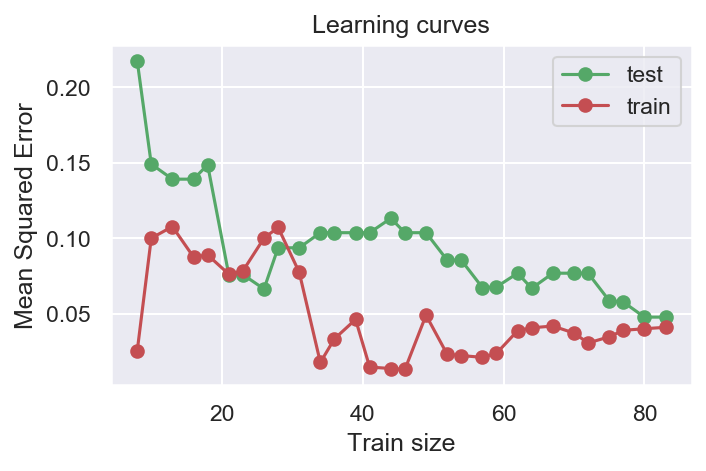

In [15]:
# Visualise training curves to determine if the model is overfitting
plot_learning_curve(clf, X_train, y_train)


#### Classification SU(1,1)

In [20]:
# run grid search
GRID_SEARCH = False # set to true if you would like to run a grid search over the param space
grid_search_test_name = "FULL_IRIS"

if GRID_SEARCH:
    print("Starting grid search...")
    # fix C to the best param found in the RBF kernel
    results_su1 = grid_search_SU("SU1",grid_search_test_name, X_train, y_train,  X_test, y_test,
                               c_space = [c], alpha_space = np.arange(0,10,0.01),
                               k_space =range(0,10), z_space = np.arange(0,10,0.01))
else:
    print("Skipping grid search...")

Skipping grid search...


In [21]:
# load grid search
grid_search_test_name = "FULL_IRIS"
results_su1 = pd.read_csv(MY_PATH + "grid_search/SU1_" + grid_search_test_name + ".csv")
best_su1 = results_su1[ results_su1["Precision"] == results_su1["Precision"].max() ]
print("Showing params that contributed to the best results:")
best_su1

Showing params that contributed to the best results:


,C,alpha,z,k,Precision,Recall,F-Score,Support
1116,1.0,0.1,1.6,1.0,1.0,1.0,1.0,45.0
1117,1.0,0.1,1.7,1.0,1.0,1.0,1.0,45.0
1118,1.0,0.1,1.8,1.0,1.0,1.0,1.0,45.0
1119,1.0,0.1,1.9,1.0,1.0,1.0,1.0,45.0
1120,1.0,0.1,2.0,1.0,1.0,1.0,1.0,45.0
...,...,...,...,...,...,...,...,...
99501,1.0,9.9,0.1,5.0,1.0,1.0,1.0,45.0
99601,1.0,9.9,0.1,6.0,1.0,1.0,1.0,45.0
99701,1.0,9.9,0.1,7.0,1.0,1.0,1.0,45.0
99801,1.0,9.9,0.1,8.0,1.0,1.0,1.0,45.0


In [22]:
import matplotlib.pyplot as plt
# best params:
c = best_su1.iloc[0]["C"]
alpha = best_su1.iloc[0]["alpha"]
k = best_su1.iloc[0]["k"]
z = best_su1.iloc[0]["z"]

# test best classifier  
name = 'SU1'
print("Kernel = %s\nParams\n alpha = %f\tC = %f\tk = %f\tz = %f" %(name, alpha, c, k, z))
clf = svm.SVC(kernel=SU1Kernel(alpha=alpha, k=k, z=z), C = c)
  
# fit data to classier
print("Fitting data...")
clf.fit(X_train, y_train)

# save model to file
print("Saving model to file...")
filename = 'iris_su1_model.sav'
pickle.dump(clf, open(MY_PATH + "models/" + filename, 'wb'))


Kernel = SU1
Params
 alpha = 0.100000	C = 1.000000	k = 1.000000	z = 1.600000
Fitting data...
Saving model to file...


In [23]:
# make prediction
print("Making prediction...")
y_pred = clf.predict(X_test)

# evaluate classifier
print("Evaluation: SU1 kernel")
rep = classification_report(y_test,y_pred)
print( rep )


Making prediction...
Evaluation: SU1 kernel
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       1.00      1.00      1.00        12
           2       1.00      1.00      1.00        13

    accuracy                           1.00        45
   macro avg       1.00      1.00      1.00        45
weighted avg       1.00      1.00      1.00        45



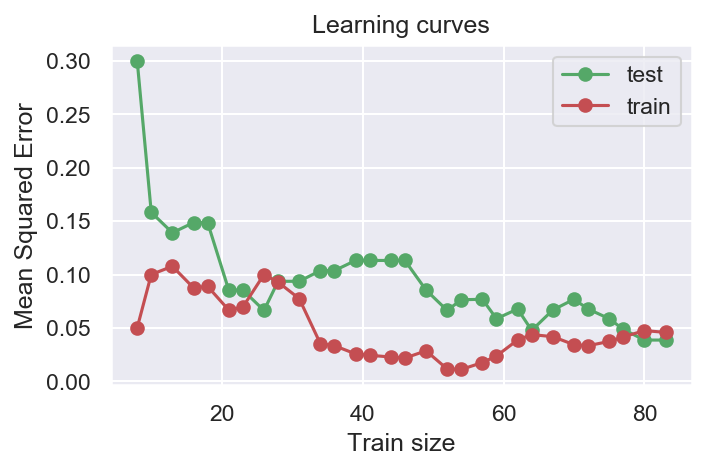

In [24]:
# Visualise training curves to determine if the model is overfitting
plot_learning_curve(clf, X_train, y_train)


#### Classification SU(2)

In [14]:
# run grid search
GRID_SEARCH = Flase # set to true if you would like to run a grid search over the param space
grid_search_test_name = "FULL_IRIS_v2"

c = 1.0
if GRID_SEARCH:
    print("Starting grid search...")
    # fix C to the best param found in the RBF kernel
    results_su1 = grid_search_SU("SU2",grid_search_test_name, X_train, y_train,  X_test, y_test,
                               c_space = [c], alpha_space = np.arange(0,5,0.1),
                               k_space =range(0,10), z_space = np.arange(0,5,0.1))
else:
    print("Skipping grid search...")
  

Starting grid search...
α = 0.000000

α = 2.000000

α = 4.000000



In [15]:
# load grid search
grid_search_test_name = "FULL_IRIS_v2"
results_su2 = pd.read_csv(MY_PATH + "grid_search/SU2_" + grid_search_test_name + ".csv")
best_su2 = results_su2[ results_su2["Precision"] == results_su2["Precision"].max() ]
print("Showing params that contributed to the best results:")
best_su2

Showing params that contributed to the best results:


,C,alpha,z,k,Precision,Recall,F-Score,Support
568,1.0,0.1,1.8,1.0,1.0,1.0,1.0,45.0
569,1.0,0.1,1.9,1.0,1.0,1.0,1.0,45.0
570,1.0,0.1,2.0,1.0,1.0,1.0,1.0,45.0
571,1.0,0.1,2.1,1.0,1.0,1.0,1.0,45.0
572,1.0,0.1,2.2,1.0,1.0,1.0,1.0,45.0
...,...,...,...,...,...,...,...,...
24951,1.0,4.9,0.1,9.0,1.0,1.0,1.0,45.0
24969,1.0,4.9,1.9,9.0,1.0,1.0,1.0,45.0
24971,1.0,4.9,2.1,9.0,1.0,1.0,1.0,45.0
24989,1.0,4.9,3.9,9.0,1.0,1.0,1.0,45.0


In [16]:
import matplotlib.pyplot as plt
# best params:

c = best_su2.iloc[0]["C"]
alpha = best_su2.iloc[0]["alpha"]
k = best_su2.iloc[0]["k"]
z = best_su2.iloc[0]["z"]

# test best classifier  
name = 'SU2'
print("Kernel = %s\nParams\n alpha = %f\tC = %f\tk = %f\tz = %f" %(name, alpha, c, k, z))
clf = svm.SVC(kernel=SU2Kernel(alpha=alpha, k=k, z=z), C = c)
  
# fit data to classier
print("Fitting data...")
clf.fit(X_train, y_train)

# save model to file
print("Saving model to file...")
filename = 'iris_su2_model.sav'
pickle.dump(clf, open(MY_PATH + "models/" + filename, 'wb'))


Kernel = SU2
Params
 alpha = 0.100000	C = 1.000000	k = 1.000000	z = 1.800000
Fitting data...
Saving model to file...


In [17]:
# make prediction
print("Making prediction...")
y_pred = clf.predict(X_test)

# evaluate classifier
print("Evaluation: SU2 kernel")
rep = classification_report(y_test,y_pred)
print( rep )


Making prediction...
Evaluation: SU2 kernel
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       1.00      1.00      1.00        12
           2       1.00      1.00      1.00        13

    accuracy                           1.00        45
   macro avg       1.00      1.00      1.00        45
weighted avg       1.00      1.00      1.00        45



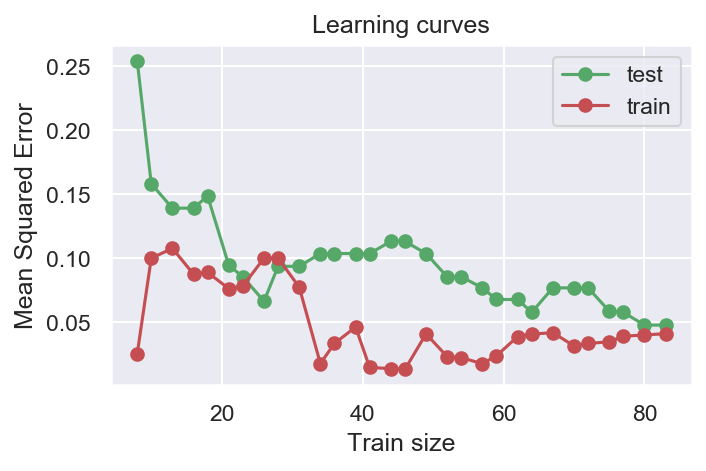

In [18]:
# Visualise training curves to determine if the model is overfitting
plot_learning_curve(clf, X_train, y_train)


### Moons Data

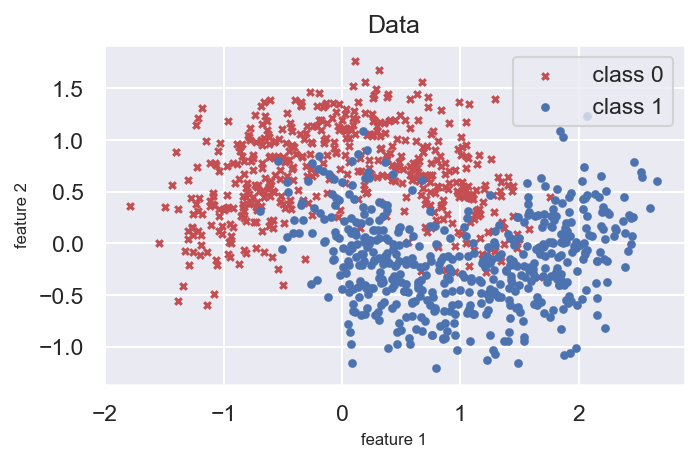

In [19]:
 # generate data
X, y = make_moons(n_samples= 1000,  random_state=515, noise=0.3 )
plot_dataset( X, y, [0,1], "Data")

# generate train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 515)

#### RBF

In [86]:
# run grid search
GRID_SEARCH = False # set to true if you would like to run a grid search over the param space
grid_search_test_name = "Moons_0.3"

if GRID_SEARCH:
    print("Starting grid search...")
    c_space = np.arange(1,100,1)          # specify the search space for param C
    γ_space = np.arange(0.01,5.01,0.01)   # spcify the search space for param γ
    results_rbf = grid_search_RBF( X_train, y_train, X_test, y_test, grid_search_test_name, c_space=c_space, g_space=γ_space)
else:
    print("Skipping grid search...")


Skipping grid search...


In [87]:
# load grid search
grid_search_test_name = "Moons_0.3"
results_rbf = pd.read_csv(MY_PATH + "grid_search/RBF_" + grid_search_test_name + ".csv")
best_rbf = results_rbf[ results_rbf["Precision"] == results_rbf["Precision"].max() ]
print("Showing params that contributed to the best results:")
best_rbf

Showing params that contributed to the best results:


,C,g,Precision,Recall,F-Score,Support
52,1.0,0.53,0.93,0.92,0.92,300.0
53,1.0,0.54,0.93,0.92,0.92,300.0
68,1.0,0.69,0.93,0.92,0.92,300.0
83,1.0,0.84,0.93,0.92,0.92,300.0
92,1.0,0.93,0.93,0.92,0.92,300.0
...,...,...,...,...,...,...
49179,99.0,1.80,0.93,0.92,0.92,300.0
49180,99.0,1.81,0.93,0.92,0.92,300.0
49181,99.0,1.82,0.93,0.92,0.92,300.0
49182,99.0,1.83,0.93,0.92,0.92,300.0


In [88]:
c = best_rbf.iloc[0]["C"]
g = best_rbf.iloc[0]["g"]

# test best classifier  
name = 'My RBF Kernel'
print("Kernel = %s\nModel\'s params:\n\tGamma = %f\tC = %f\n" %(name, g, c))
clf = svm.SVC(kernel=myRBF(gamma=g), C = c)
  
# fit data to classier
print("Fitting data...")
clf.fit(X_train, y_train)

# save model to file
print("Saving model to file...")
filename = 'moons_rbf_model.sav'
pickle.dump(clf, open(MY_PATH + "models/" + filename, 'wb'))


Kernel = My RBF Kernel
Model's params:
	Gamma = 0.530000	C = 1.000000

Fitting data...
Saving model to file...


In [89]:
print("Loading model...")
filename = 'moons_rbf_model.sav'
clf = pickle.load(open(MY_PATH + "models/" + filename, 'rb'))

# make prediction
print("Making prediction...")
y_pred = clf.predict(X_test)

# evaluate classifier
print("Evaluation: RBF kernel...\n")
rep = classification_report(y_test,y_pred)
print( rep )


Loading model...
Making prediction...
Evaluation: RBF kernel...

              precision    recall  f1-score   support

           0       0.88      0.96      0.92       142
           1       0.97      0.89      0.92       158

    accuracy                           0.92       300
   macro avg       0.92      0.93      0.92       300
weighted avg       0.93      0.92      0.92       300



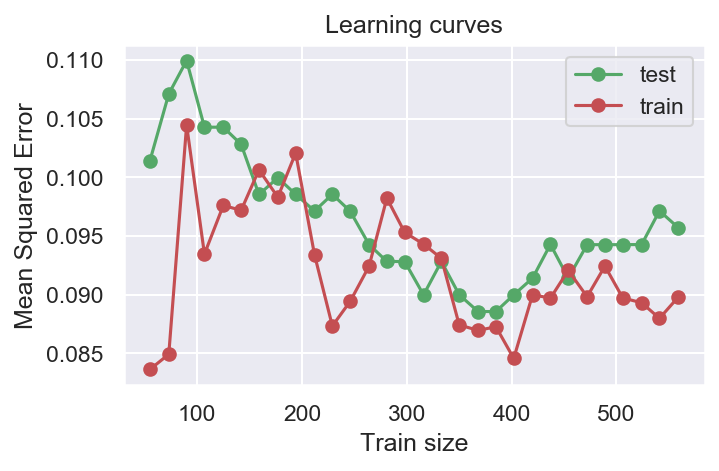

In [90]:
# Visualise training curves to determine if the model is overfitting
plot_learning_curve(clf, X_train, y_train)

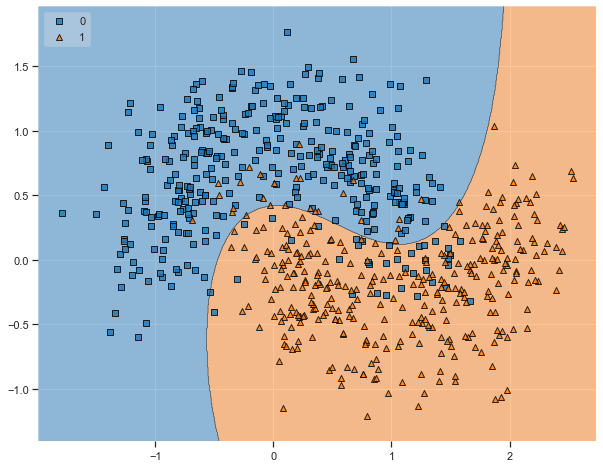

In [91]:

# plot decision boundary over training data
plt.figure(figsize=(10,8))
plot_decision_regions(X_train, y_train, clf=clf, legend=2, zoom_factor=5 )

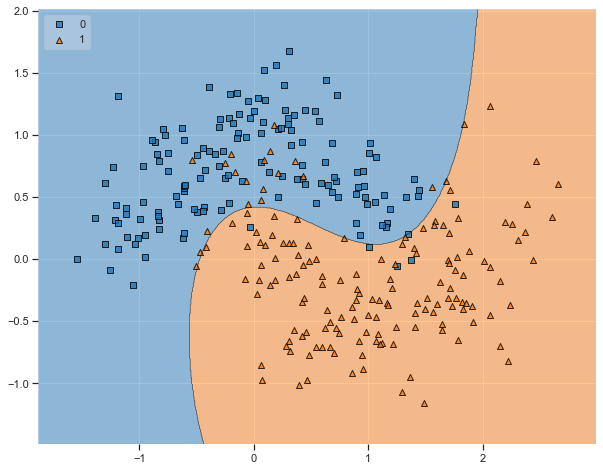

In [92]:

# plot decision boundary over training data
plt.figure(figsize=(10,8))
plot_decision_regions(X_test, y_test, clf=clf, legend=2, zoom_factor=3 )

#### SU(1,1)

In [ ]:
# run grid search
GRID_SEARCH = False # set to true if you would like to run a grid search over the param space
grid_search_test_name = "Moons_v0.3"
c = best_rbf.iloc[0]["C"]

if GRID_SEARCH:
    print("Starting grid search...")
    # fix C to the best param found in the RBF kernel
    results_su1 = grid_search_SU("SU1",grid_search_test_name, X_train, y_train,  X_test, y_test,
                               c_space = [c], alpha_space = np.arange(0,10,0.1),
                               k_space =range(0,10), z_space = np.arange(0,10,0.1))
else:
    print("Skipping grid search...")
  

In [52]:
# load grid search
grid_search_test_name = "Moons_v0.3"
results_su1 = pd.read_csv(MY_PATH + "grid_search/SU1_" + grid_search_test_name + ".csv")
best_su1 = results_su1[ results_su1["Precision"] == results_su1["Precision"].max() ]
print("Showing params that contributed to the best results:")
best_su1

Showing params that contributed to the best results:


,C,alpha,z,k,Precision,Recall,F-Score,Support
1126,1.0,0.1,2.6,1.0,0.93,0.92,0.92,300.0
1127,1.0,0.1,2.7,1.0,0.93,0.92,0.92,300.0
1130,1.0,0.1,3.0,1.0,0.93,0.92,0.92,300.0
1131,1.0,0.1,3.1,1.0,0.93,0.92,0.92,300.0
1132,1.0,0.1,3.2,1.0,0.93,0.92,0.92,300.0
...,...,...,...,...,...,...,...,...
99402,1.0,9.9,0.2,4.0,0.93,0.92,0.92,300.0
99502,1.0,9.9,0.2,5.0,0.93,0.92,0.92,300.0
99602,1.0,9.9,0.2,6.0,0.93,0.92,0.92,300.0
99801,1.0,9.9,0.1,8.0,0.93,0.92,0.92,300.0


In [61]:
import matplotlib.pyplot as plt
# best params:

c = best_su1.iloc[0]["C"]
alpha = best_su1.iloc[0]["alpha"]
k = best_su1.iloc[0]["k"]
z = best_su1.iloc[0]["z"]

# test best classifier  
name = 'SU1'
print("Kernel = %s\nParams\n alpha = %f\tC = %f\tk = %f\tz = %f" %(name, alpha, c, k, z))
clf = svm.SVC(kernel=SU1Kernel(alpha=alpha, k=k, z=z), C = c)
  
# fit data to classier
print("Fitting data...")
clf.fit(X_train, y_train)

# save model to file
print("Saving model to file...")
filename = 'moons_su1_model.sav'
pickle.dump(clf, open(MY_PATH + "models/" + filename, 'wb'))


Kernel = SU1
Params
 alpha = 0.100000	C = 1.000000	k = 1.000000	z = 2.600000
Fitting data...
Saving model to file...


In [64]:
print("Loading model...")
filename = 'moons_su1_model.sav'
clf = pickle.load(open(MY_PATH + "models/" + filename, 'rb'))

# make prediction
print("Making prediction...")
y_pred = clf.predict(X_test)

# evaluate classifier
print("Evaluation: SU1 kernel")
rep = classification_report(y_test,y_pred)
print( rep )


Loading model...
Making prediction...
Evaluation: SU1 kernel
              precision    recall  f1-score   support

           0       0.87      0.97      0.92       142
           1       0.97      0.87      0.92       158

    accuracy                           0.92       300
   macro avg       0.92      0.92      0.92       300
weighted avg       0.93      0.92      0.92       300



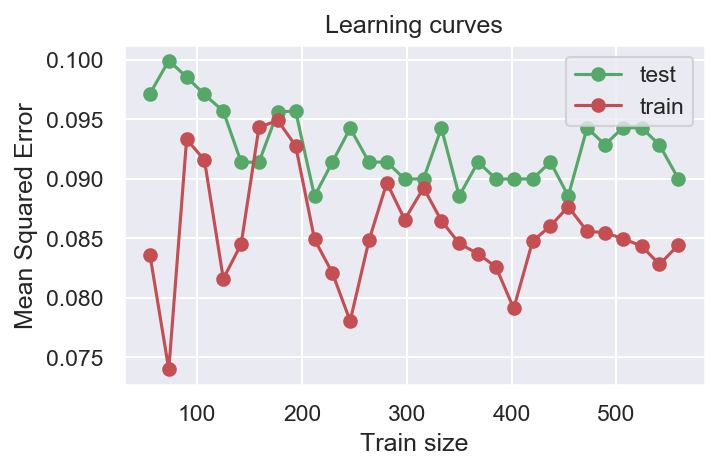

In [65]:
# Visualise training curves to determine if the model is overfitting
plot_learning_curve(clf, X_train, y_train)


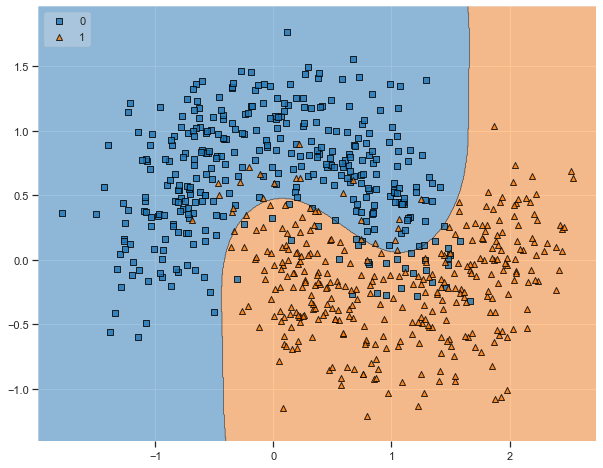

In [66]:

# plot decision boundary over training data
plt.figure(figsize=(10,8))
plot_decision_regions(X_train, y_train, clf=clf, legend=2, zoom_factor=5 )

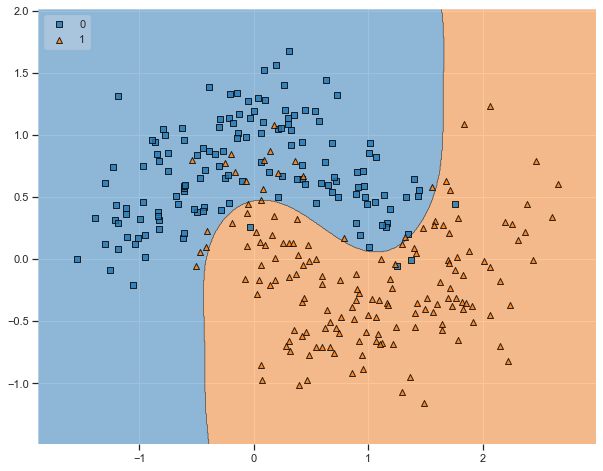

In [67]:

# plot decision boundary over training data
plt.figure(figsize=(10,8))
plot_decision_regions(X_test, y_test, clf=clf, legend=2, zoom_factor=3 )

#### SU(2)


In [21]:
# run grid search
GRID_SEARCH = False # set to true if you would like to run a grid search over the param space
grid_search_test_name = "Moons_v0.3_v2"
c = 1.0

if GRID_SEARCH:
    print("Starting grid search...")
    # fix C to the best param found in the RBF kernel
    results_su2 = grid_search_SU("SU2",grid_search_test_name, X_train, y_train,  X_test, y_test,
                               c_space = [c], alpha_space = np.arange(0,5,0.1),
                               k_space =range(0,10), z_space = np.arange(0,10,0.1))
else:
    print("Skipping grid search...")
  

Starting grid search...
α = 0.000000

α = 2.000000

α = 4.000000



In [42]:
# load grid search
grid_search_test_name = "Moons_v0.3_v2"
results_su2 = pd.read_csv(MY_PATH + "grid_search/SU2_" + grid_search_test_name + ".csv")
best_su2 = results_su2[ results_su2["Precision"] == results_su2["Precision"].max() ]
print("Showing params that contributed to the best results:")
best_su2

Showing params that contributed to the best results:


,C,alpha,z,k,Precision,Recall,F-Score,Support
1132,1.0,0.1,3.2,1.0,0.93,0.92,0.92,300.0
1151,1.0,0.1,5.1,1.0,0.93,0.92,0.92,300.0
1189,1.0,0.1,8.9,1.0,0.93,0.92,0.92,300.0
1192,1.0,0.1,9.2,1.0,0.93,0.92,0.92,300.0
1221,1.0,0.1,2.1,2.0,0.93,0.92,0.92,300.0
...,...,...,...,...,...,...,...,...
49978,1.0,4.9,7.8,9.0,0.93,0.92,0.92,300.0
49979,1.0,4.9,7.9,9.0,0.93,0.92,0.92,300.0
49982,1.0,4.9,8.2,9.0,0.93,0.92,0.92,300.0
49983,1.0,4.9,8.3,9.0,0.93,0.92,0.92,300.0


In [43]:
import matplotlib.pyplot as plt
# best params:

c = best_su2.iloc[0]["C"]
alpha = best_su2.iloc[0]["alpha"]
k = best_su2.iloc[0]["k"]
z = best_su2.iloc[0]["z"]

# test best classifier  
name = 'SU2'
print("Kernel = %s\nParams\n alpha = %f\tC = %f\tk = %f\tz = %f" %(name, alpha, c, k, z))
clf = svm.SVC(kernel=SU2Kernel(alpha=alpha, k=k, z=z), C = c)
  
# fit data to classier
print("Fitting data...")
clf.fit(X_train, y_train)

# save model to file
print("Saving model to file...")
filename = 'moons_su2_model.sav'
pickle.dump(clf, open(MY_PATH + "models/" + filename, 'wb'))


Kernel = SU2
Params
 alpha = 0.100000	C = 1.000000	k = 1.000000	z = 3.200000
Fitting data...
Saving model to file...


In [44]:
print("Loading model...")
filename = 'moons_su2_model.sav'
clf = pickle.load(open(MY_PATH + "models/" + filename, 'rb'))

# make prediction
print("Making prediction...")
y_pred = clf.predict(X_test)

# evaluate classifier
print("Evaluation: SU2 kernel")
rep = classification_report(y_test,y_pred)
print( rep )


Loading model...
Making prediction...
Evaluation: SU2 kernel
              precision    recall  f1-score   support

           0       0.87      0.82      0.84       142
           1       0.85      0.89      0.87       158

    accuracy                           0.86       300
   macro avg       0.86      0.86      0.86       300
weighted avg       0.86      0.86      0.86       300



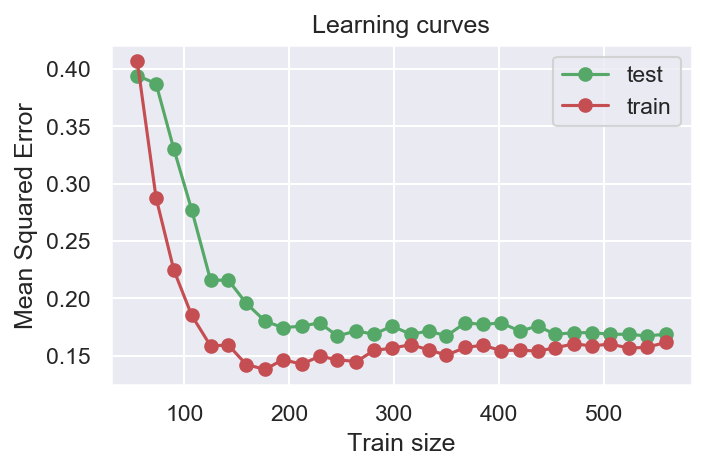

In [45]:
# Visualise training curves to determine if the model is overfitting
plot_learning_curve(clf, X_train, y_train)


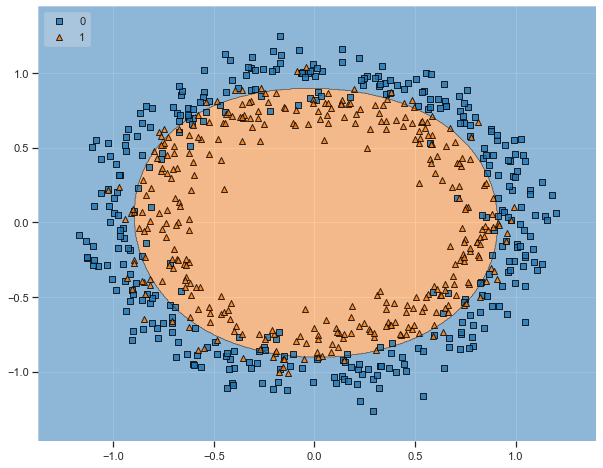

In [46]:

# plot decision boundary over training data
plt.figure(figsize=(10,8))
plot_decision_regions(X_train, y_train, clf=clf, legend=2, zoom_factor=5 )

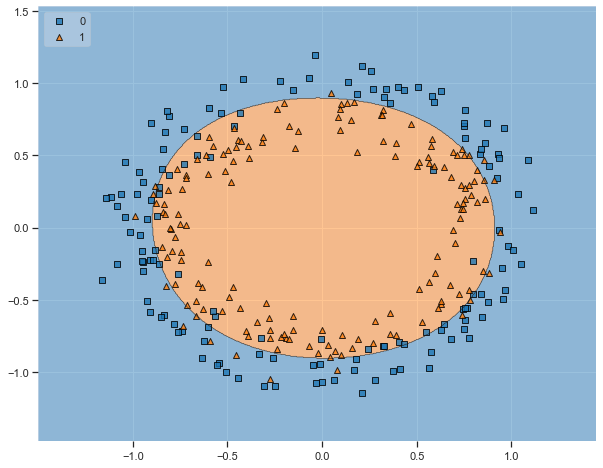

In [47]:

# plot decision boundary over training data
plt.figure(figsize=(10,8))
plot_decision_regions(X_test, y_test, clf=clf, legend=2, zoom_factor=3 )

### Circles Data

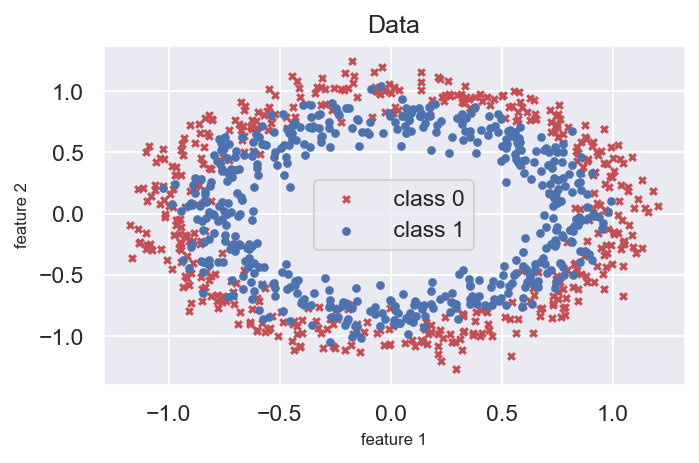

In [48]:
 # generate data
X, y = make_circles(n_samples= 1000,  random_state=515, noise=0.1 )
plot_dataset( X, y, [0,1], "Data")

# generate train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 515)

#### RBF

In [96]:
# run grid search
GRID_SEARCH = False # set to true if you would like to run a grid search over the param space
grid_search_test_name = "Circles_0.1"

if GRID_SEARCH:
    print("Starting grid search...")
    c_space = np.arange(1,100,1)          # specify the search space for param C
    γ_space = np.arange(0.01,5.01,0.01)   # spcify the search space for param γ
    results_rbf = grid_search_RBF( X_train, y_train, X_test, y_test, grid_search_test_name, c_space=c_space, g_space=γ_space)
else:
    print("Skipping grid search...")


Skipping grid search...


In [97]:
# load grid search
grid_search_test_name = "Circles_0.1_v2"
results_rbf = pd.read_csv(MY_PATH + "grid_search/RBF_" + grid_search_test_name + ".csv")
best_rbf = results_rbf[ results_rbf["Precision"] == results_rbf["Precision"].max() ]
print("Showing params that contributed to the best results:")
best_rbf


Showing params that contributed to the best results:


,C,g,Precision,Recall,F-Score,Support
34,1.0,0.35,0.86,0.86,0.86,300.0
86,1.0,0.87,0.86,0.86,0.86,300.0
87,1.0,0.88,0.86,0.86,0.86,300.0
88,1.0,0.89,0.86,0.86,0.86,300.0
89,1.0,0.90,0.86,0.86,0.86,300.0
...,...,...,...,...,...,...
49184,99.0,1.85,0.86,0.85,0.85,300.0
49185,99.0,1.86,0.86,0.85,0.85,300.0
49186,99.0,1.87,0.86,0.85,0.85,300.0
49187,99.0,1.88,0.86,0.85,0.85,300.0


In [98]:
c = best_rbf.iloc[0]["C"]
g = best_rbf.iloc[0]["g"]

# test best classifier  
name = 'My RBF Kernel'
print("Kernel = %s\nModel\'s params:\n\tGamma = %f\tC = %f\n" %(name, g, c))
clf = svm.SVC(kernel=myRBF(gamma=g), C = c)
  
# fit data to classier
print("Fitting data...")
clf.fit(X_train, y_train)

# save model to file
print("Saving model to file...")
filename = 'circles_rbf_model.sav'
pickle.dump(clf, open(MY_PATH + "models/" + filename, 'wb'))


Kernel = My RBF Kernel
Model's params:
	Gamma = 0.350000	C = 1.000000

Fitting data...
Saving model to file...


In [99]:
print("Loading model...")
filename = 'circles_rbf_model.sav'
clf = pickle.load(open(MY_PATH + "models/" + filename, 'rb'))

# make prediction
print("Making prediction...")
y_pred = clf.predict(X_test)

# evaluate classifier
print("Evaluation: RBF kernel...\n")
rep = classification_report(y_test,y_pred)
print( rep )


Loading model...
Making prediction...
Evaluation: RBF kernel...

              precision    recall  f1-score   support

           0       0.89      0.80      0.84       142
           1       0.83      0.91      0.87       158

    accuracy                           0.86       300
   macro avg       0.86      0.85      0.86       300
weighted avg       0.86      0.86      0.86       300



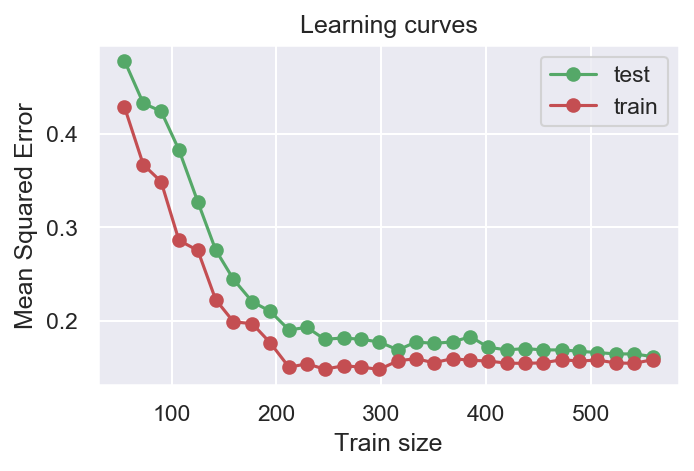

In [100]:
# plot learning curve
plot_learning_curve(clf, X_train, y_train)


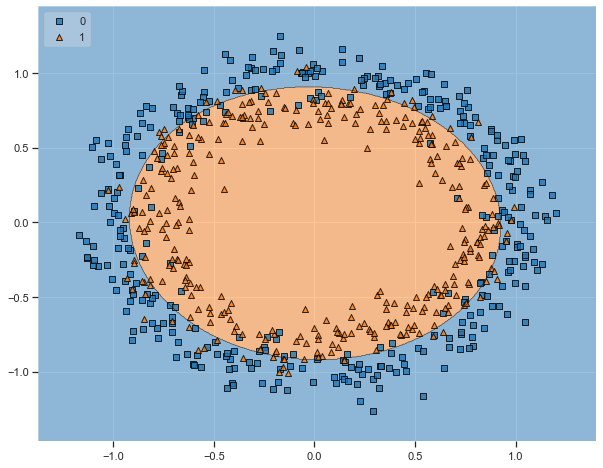

In [101]:

# plot decision boundary over training data
plt.figure(figsize=(10,8))
plot_decision_regions(X_train, y_train, clf=clf, legend=2, zoom_factor=5 )

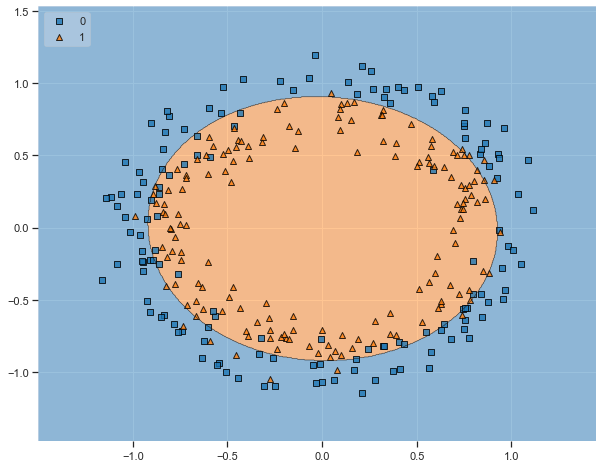

In [102]:

# plot decision boundary over training data
plt.figure(figsize=(10,8))
plot_decision_regions(X_test, y_test, clf=clf, legend=2, zoom_factor=3 )

#### SU(1,1)

In [103]:
# run grid search
GRID_SEARCH = False # set to true if you would like to run a grid search over the param space
grid_search_test_name = "Circles_0.1"

c = best_rbf.iloc[0]["C"]

if GRID_SEARCH:
    print("Starting grid search...")
    # fix C to the best param found in the RBF kernel
    results_su1 = grid_search_SU("SU1",grid_search_test_name, X_train, y_train,  X_test, y_test,
                               c_space = [c], alpha_space = np.arange(0,5,0.1),
                               k_space =range(0,5), z_space = np.arange(0,5,0.1))
else:
    print("Skipping grid search...")
  

Skipping grid search...


In [104]:
# load grid search
grid_search_test_name = "Circles_0.1"
results_su1 = pd.read_csv(MY_PATH + "grid_search/SU1_" + grid_search_test_name + ".csv")
best_su1 = results_su1[ results_su1["Precision"] == results_su1["Precision"].max() ]
print("Showing params that contributed to the best results:")
best_su1


Showing params that contributed to the best results:


,C,alpha,z,k,Precision,Recall,F-Score,Support
371,1.0,0.1,2.1,2.0,0.86,0.86,0.86,300.0
373,1.0,0.1,2.3,2.0,0.86,0.86,0.86,300.0
416,1.0,0.1,1.6,3.0,0.86,0.86,0.86,300.0
418,1.0,0.1,1.8,3.0,0.86,0.86,0.86,300.0
464,1.0,0.1,1.4,4.0,0.86,0.86,0.86,300.0
...,...,...,...,...,...,...,...,...
10603,1.0,4.2,0.3,2.0,0.86,0.86,0.86,300.0
12103,1.0,4.8,0.3,2.0,0.86,0.86,0.86,300.0
12202,1.0,4.8,0.2,4.0,0.86,0.86,0.86,300.0
12353,1.0,4.9,0.3,2.0,0.86,0.86,0.86,300.0


In [105]:
import matplotlib.pyplot as plt
# best params:

c = best_su1.iloc[0]["C"]
alpha = best_su1.iloc[0]["alpha"]
k = best_su1.iloc[0]["k"]
z = best_su1.iloc[0]["z"]

# test best classifier  
name = 'SU1'
print("Kernel = %s\nParams\n alpha = %f\tC = %f\tk = %f\tz = %f" %(name, alpha, c, k, z))
clf = svm.SVC(kernel=SU1Kernel(alpha=alpha, k=k, z=z), C = c)
  
# fit data to classier
print("Fitting data...")
clf.fit(X_train, y_train)

# save model to file
print("Saving model to file...")
filename = 'circles_su1_model.sav'
pickle.dump(clf, open(MY_PATH + "models/" + filename, 'wb'))


Kernel = SU1
Params
 alpha = 0.100000	C = 1.000000	k = 2.000000	z = 2.100000
Fitting data...
Saving model to file...


In [106]:
print("Loading model...")
filename = 'circles_su1_model.sav'
clf = pickle.load(open(MY_PATH + "models/" + filename, 'rb'))

# make prediction
print("Making prediction...")
y_pred = clf.predict(X_test)

# evaluate classifier
print("Evaluation: SU1 kernel")
rep = classification_report(y_test,y_pred)
print( rep )


Loading model...
Making prediction...
Evaluation: SU1 kernel
              precision    recall  f1-score   support

           0       0.86      0.83      0.85       142
           1       0.85      0.88      0.87       158

    accuracy                           0.86       300
   macro avg       0.86      0.86      0.86       300
weighted avg       0.86      0.86      0.86       300



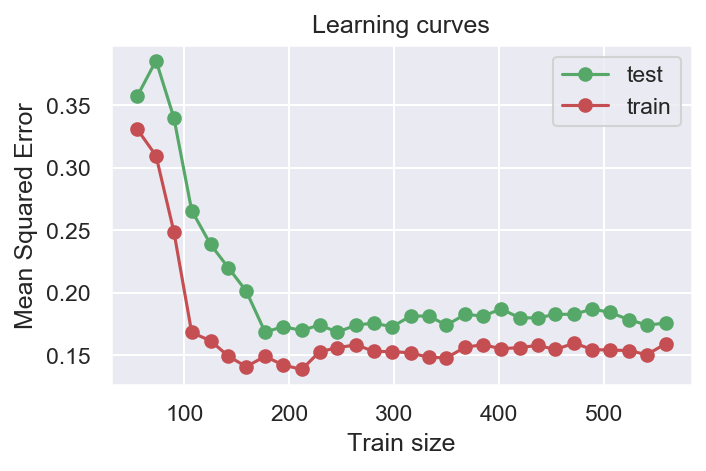

In [107]:
# Visualise training curves to determine if the model is overfitting
plot_learning_curve(clf, X_train, y_train)


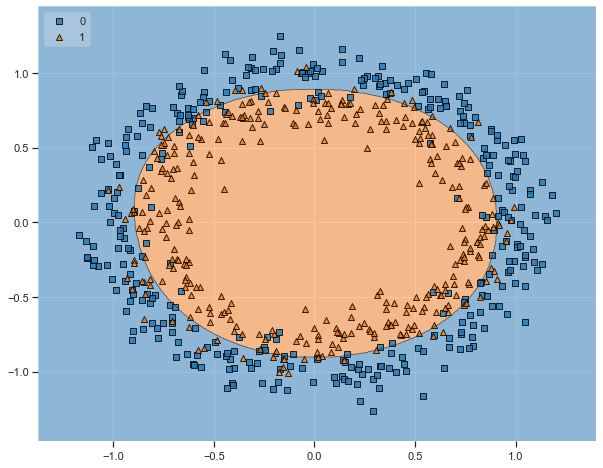

In [108]:

# plot decision boundary over training data
plt.figure(figsize=(10,8))
plot_decision_regions(X_train, y_train, clf=clf, legend=2, zoom_factor=5 )


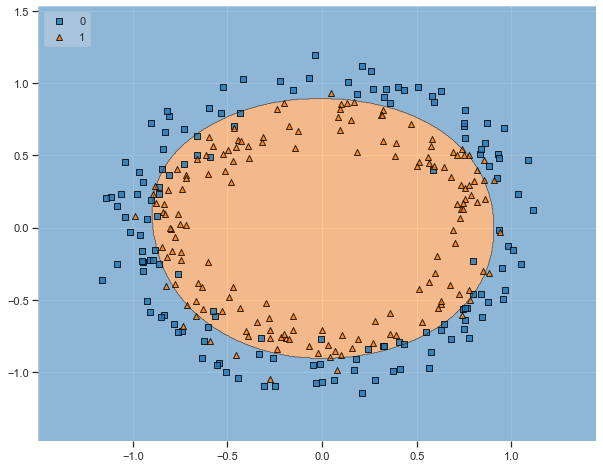

In [109]:

# plot decision boundary over training data
plt.figure(figsize=(10,8))
plot_decision_regions(X_test, y_test, clf=clf, legend=2, zoom_factor=3 )

#### SU(2)

In [30]:
# run grid search
GRID_SEARCH = True # set to true if you would like to run a grid search over the param space
grid_search_test_name = "Circles_v0.1_v2"

c = 1.0
if GRID_SEARCH:
    print("Starting grid search...")
    # fix C to the best param found in the RBF kernel
    results_su2 = grid_search_SU("SU2",grid_search_test_name, X_train, y_train,  X_test, y_test,
                               c_space = [c], alpha_space = np.arange(0,5,0.1),
                               k_space =range(0,10), z_space = np.arange(0,10,0.1))
else:
    print("Skipping grid search...")
  


Starting grid search...
α = 0.000000

α = 2.000000

α = 4.000000



In [35]:
# load grid search
grid_search_test_name = "Circles_v0.1_v2"
results_su2 = pd.read_csv(MY_PATH + "grid_search/SU2_" + grid_search_test_name + ".csv")
best_su2 = results_su2[ results_su2["Precision"] == results_su2["Precision"].max() ]
print("Showing params that contributed to the best results:")
best_su2

Showing params that contributed to the best results:


,C,alpha,z,k,Precision,Recall,F-Score,Support
1239,1.0,0.1,3.9,2.0,0.87,0.87,0.87,300.0
1241,1.0,0.1,4.1,2.0,0.87,0.87,0.87,300.0
2229,1.0,0.2,2.9,2.0,0.87,0.87,0.87,300.0
4250,1.0,0.4,5.0,2.0,0.87,0.87,0.87,300.0
4290,1.0,0.4,9.0,2.0,0.87,0.87,0.87,300.0
...,...,...,...,...,...,...,...,...
47276,1.0,4.7,7.6,2.0,0.87,0.87,0.87,300.0
48255,1.0,4.8,5.5,2.0,0.87,0.87,0.87,300.0
48287,1.0,4.8,8.7,2.0,0.87,0.87,0.87,300.0
49246,1.0,4.9,4.6,2.0,0.87,0.87,0.87,300.0


In [36]:
import matplotlib.pyplot as plt
# best params:

c = best_su2.iloc[0]["C"]
alpha = best_su2.iloc[0]["alpha"]
k = best_su2.iloc[0]["k"]
z = best_su2.iloc[0]["z"]

# test best classifier  
name = 'SU2'
print("Kernel = %s\nParams\n alpha = %f\tC = %f\tk = %f\tz = %f" %(name, alpha, c, k, z))
clf = svm.SVC(kernel=SU2Kernel(alpha=alpha, k=k, z=z), C = c)
  
# fit data to classier
print("Fitting data...")
clf.fit(X_train, y_train)

# save model to file
print("Saving model to file...")
filename = 'circles_su2_model.sav'
pickle.dump(clf, open(MY_PATH + "models/" + filename, 'wb'))


Kernel = SU2
Params
 alpha = 0.100000	C = 1.000000	k = 2.000000	z = 3.900000
Fitting data...
Saving model to file...


In [33]:
print("Loading model...")
filename = 'circles_su2_model.sav'
clf = pickle.load(open(MY_PATH + "models/" + filename, 'rb'))

# make prediction
print("Making prediction...")
y_pred = clf.predict(X_test)

# evaluate classifier
print("Evaluation: SU2 kernel")
rep = classification_report(y_test,y_pred)
print( rep )


Loading model...
Making prediction...
Evaluation: SU1 kernel
              precision    recall  f1-score   support

           0       0.87      0.86      0.86       142
           1       0.87      0.88      0.88       158

    accuracy                           0.87       300
   macro avg       0.87      0.87      0.87       300
weighted avg       0.87      0.87      0.87       300



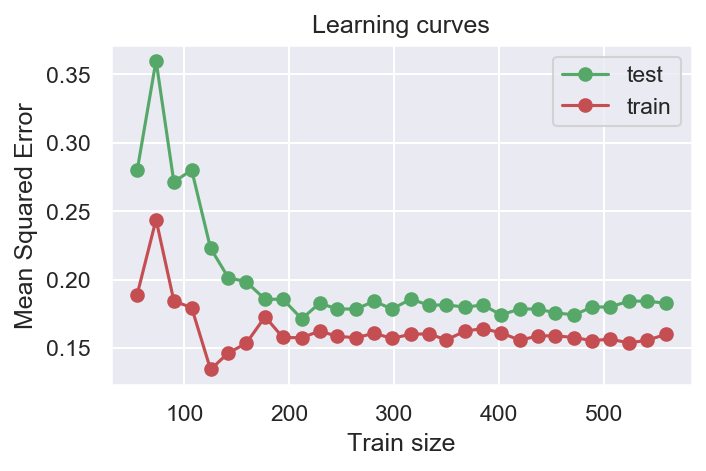

In [37]:
# Visualise training curves to determine if the model is overfitting
plot_learning_curve(clf, X_train, y_train)


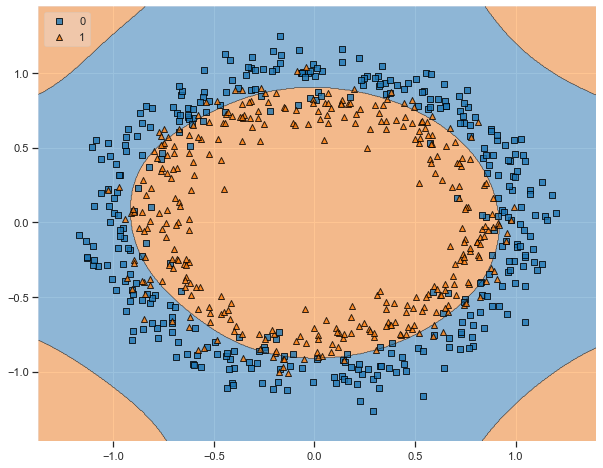

In [38]:

# plot decision boundary over training data
plt.figure(figsize=(10,8))
plot_decision_regions(X_train, y_train, clf=clf, legend=2, zoom_factor=5 )


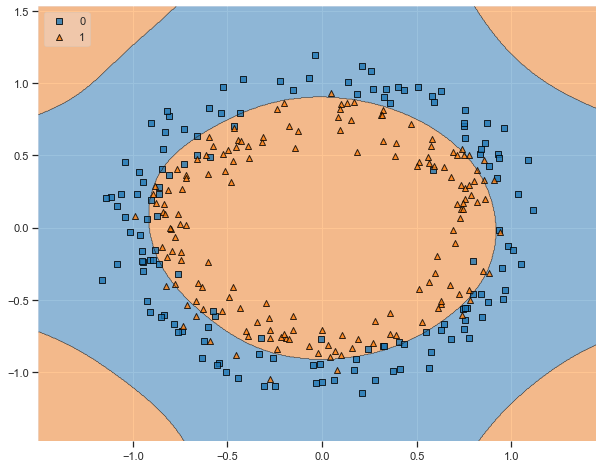

In [39]:

# plot decision boundary over training data
plt.figure(figsize=(10,8))
plot_decision_regions(X_test, y_test, clf=clf, legend=2, zoom_factor=3 )